# Box Office Revenue Distribution by Genre (Boxplot)

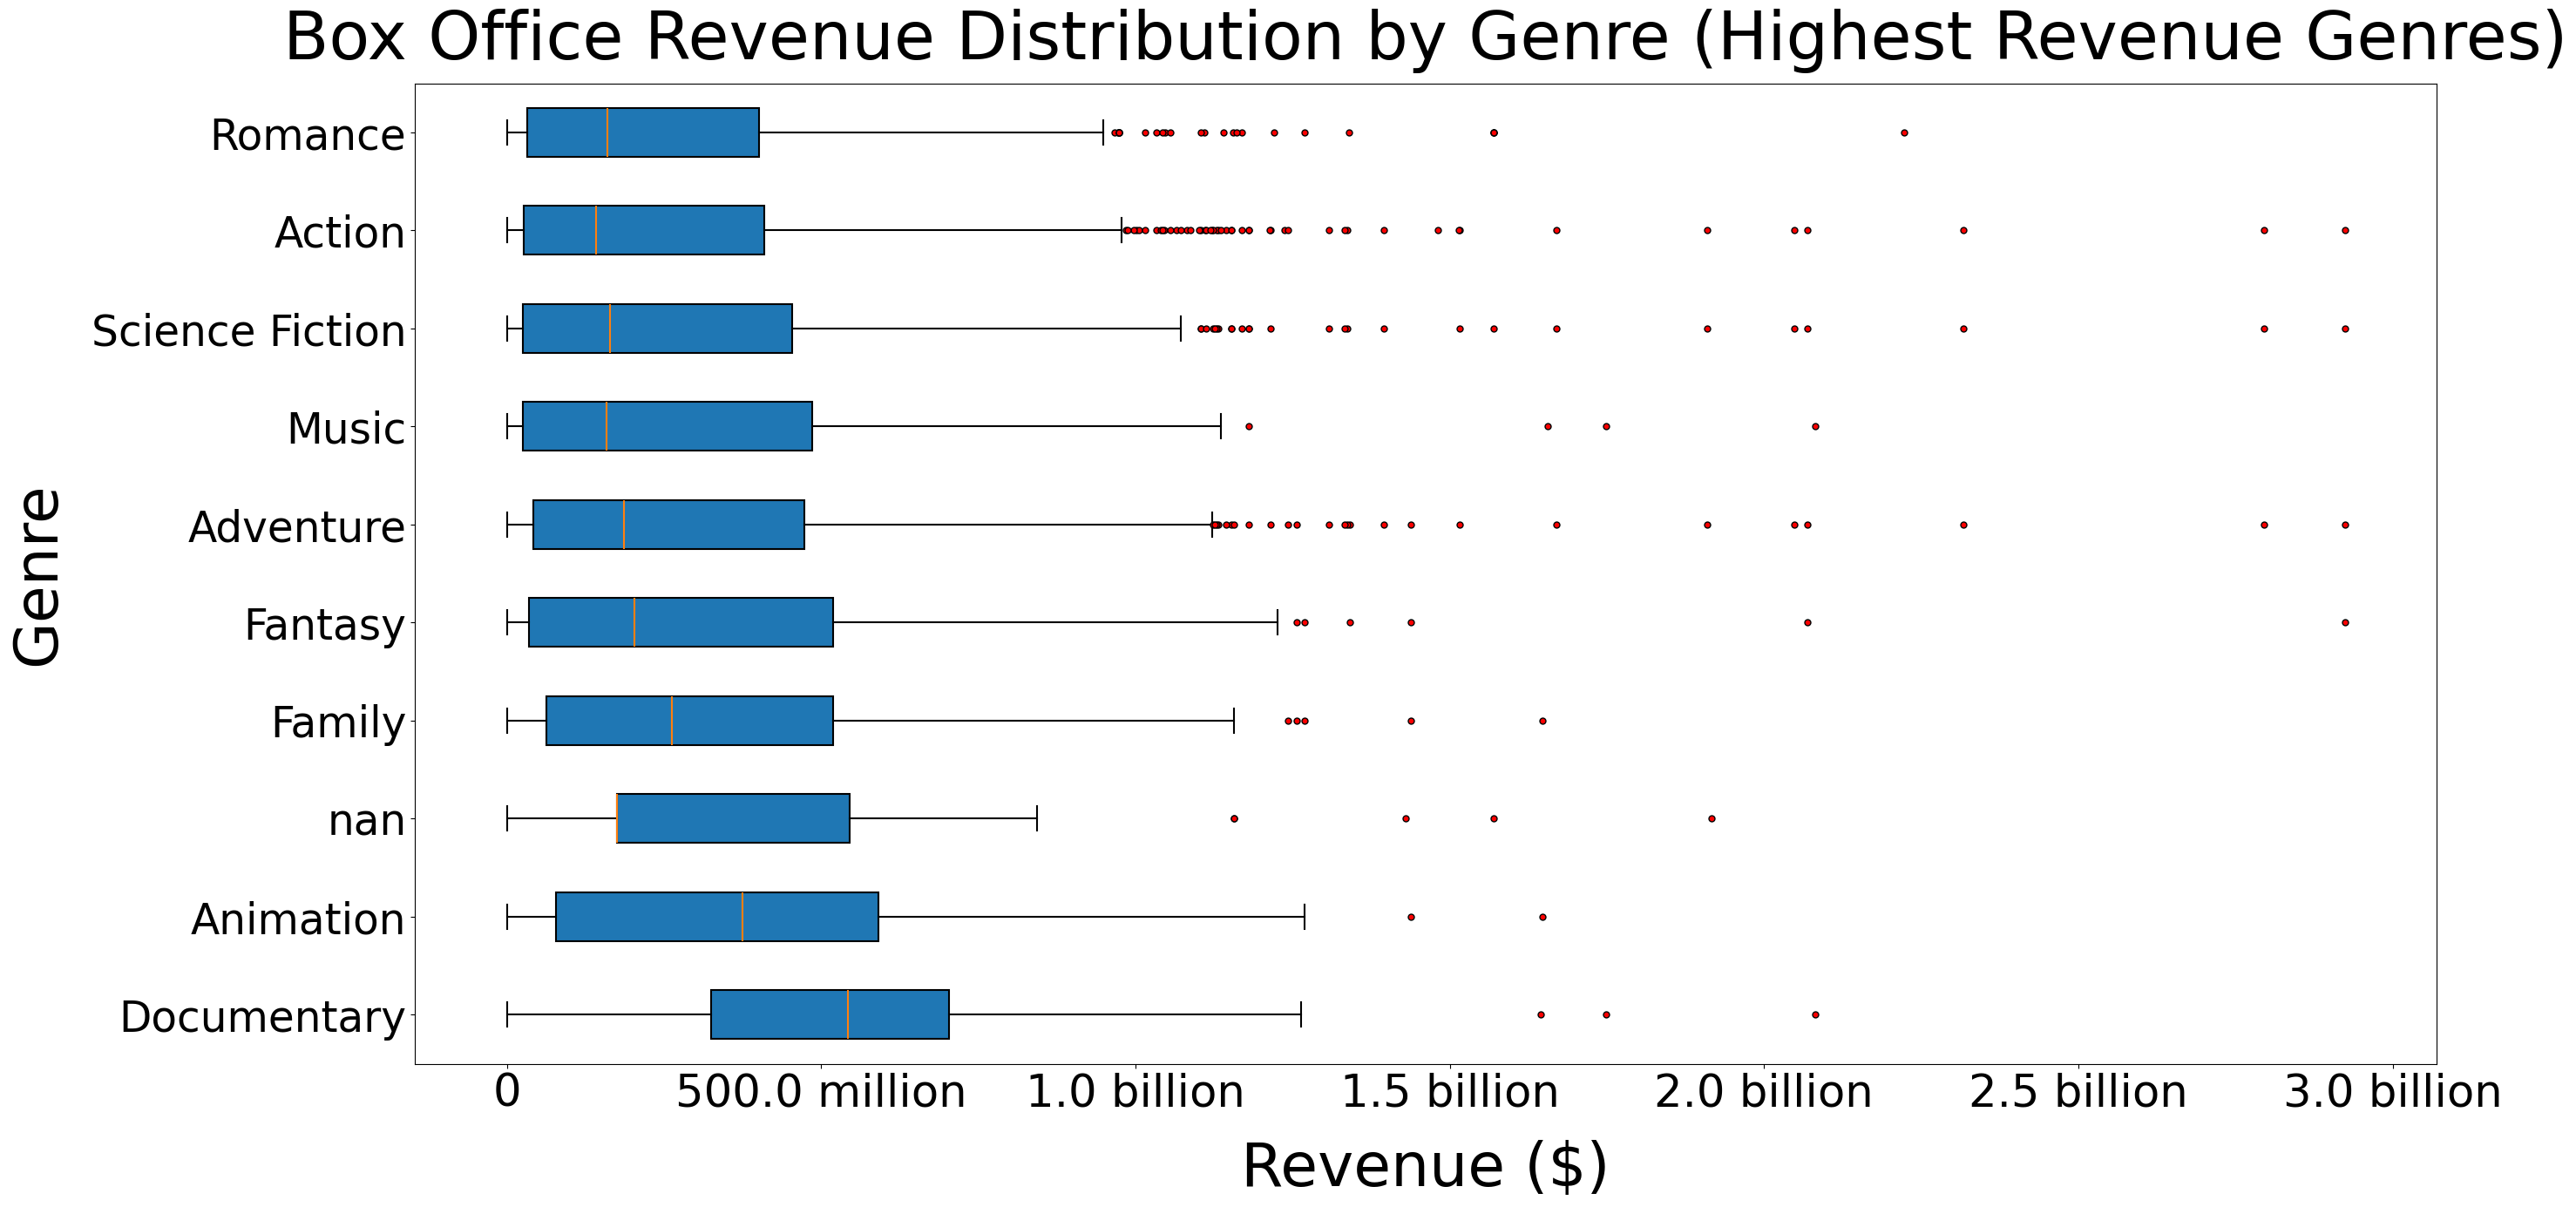

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


# ---------- Load + clean ----------
imdb = pd.read_csv("imdb_movies.csv").rename(columns={"names": "name"})
yt   = pd.read_csv("movies_youtube_sentiments.csv")

# Make sure numeric columns behave
imdb["revenue"] = pd.to_numeric(imdb.get("revenue"), errors="coerce")
yt["gross"]     = pd.to_numeric(yt.get("gross"), errors="coerce")

# Combine (keeping your original approach: concat + de-dupe by name)
movies = (
    pd.concat([imdb, yt], ignore_index=True)
      .drop_duplicates(subset="name")
      .assign(
          # clean + explode genres
          genre=lambda d: (
              d["genre"]
              .astype(str)
              .str.replace("\xa0", " ", regex=False)
              .str.split(", ")
          )
      )
      .explode("genre")
      .reset_index(drop=True)
)

# Fill revenue from gross when revenue missing/0 (matches your original logic)
movies["revenue"] = movies["revenue"].fillna(0)
movies["gross"]   = movies["gross"].fillna(0)
movies.loc[movies["revenue"].eq(0), "revenue"] = movies.loc[movies["revenue"].eq(0), "gross"]

# Remove TV Movie and keep only what we need
movies = movies.loc[movies["genre"].ne("TV Movie"), ["genre", "revenue"]].copy()


# ---------- Choose top 10 genres by mean revenue ----------
top10 = (
    movies.groupby("genre")["revenue"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

plot_df = movies[movies["genre"].isin(top10)].copy()
plot_df["genre"] = pd.Categorical(plot_df["genre"], categories=top10, ordered=True)


# ---------- Plot ----------
def money_formatter(x, _pos):
    if x >= 1e9:
        return f"{x/1e9:.1f} billion"
    if x >= 1e6:
        return f"{x/1e6:.1f} million"
    if x >= 1e3:
        return f"{x/1e3:.1f} thousand"
    return f"{x:.0f}"

fig, ax = plt.subplots(figsize=(29, 15))

plot_df.boxplot(
    column="revenue", by="genre", ax=ax, grid=False,
    vert=False,
    boxprops=dict(linestyle="-", linewidth=1.5),
    medianprops=dict(linestyle="-", linewidth=1.5),
    whiskerprops=dict(linestyle="-", linewidth=1.5),
    capprops=dict(linestyle="-", linewidth=1.5),
    showfliers=True,
    flierprops=dict(marker="o", markerfacecolor="red", markersize=5, linestyle="none"),
    patch_artist=True,
)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(money_formatter))
ax.tick_params(axis="x", labelsize=37)

plt.title("Box Office Revenue Distribution by Genre (Highest Revenue Genres)", fontsize=55, pad=20)
plt.suptitle("")
plt.ylabel("Genre", fontsize=50, labelpad=20)
plt.xlabel("Revenue ($)", fontsize=50, labelpad=20)
plt.yticks(fontsize=35)

plt.show()